<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-simplest-ageometeorological-crop-model" data-toc-modified-id="The-simplest-ageometeorological-crop-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The simplest ageometeorological crop model</a></span><ul class="toc-item"><li><span><a href="#Main-crop-modelling:-production-efficiency-model-(PEM)" data-toc-modified-id="Main-crop-modelling:-production-efficiency-model-(PEM)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Main crop modelling: production efficiency model (PEM)</a></span></li><li><span><a href="#Crop-limitations" data-toc-modified-id="Crop-limitations-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Crop limitations</a></span><ul class="toc-item"><li><span><a href="#Temperature-control" data-toc-modified-id="Temperature-control-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Temperature control</a></span></li><li><span><a href="#Water-availability" data-toc-modified-id="Water-availability-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Water availability</a></span></li></ul></li></ul></li><li><span><a href="#The-model" data-toc-modified-id="The-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The model</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import gdal
import pandas as pd
%matplotlib inline

from modis_funcs import *
from meteo_funcs import *

/home/ucfajlg/.local/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## The simplest ageometeorological crop model

### Main crop modelling: production efficiency model (PEM)

We can think of the crop turning incoming radiation into carbon, which then gets allocated to different organs (including leave, grain, roots, etc.). The simple PEM model introduced by Monteith is basically that gross primary productivity (GPP) can be written as

$$
GPP(t) = fAPAR\cdot PAR_{inc} \cdot \epsilon,
$$

where $fAPAR$ is the fraction of active photosynthetic radiation absorbed by the canopy (hence related to the amount and colour of leaves), $PAR_{inc}$ is the incoming radiation in the PAR region ($400-700 \textrm{nm}$), and $\epsilon$ is an energy conversion factor (e.g. how many grams of C per square meter do we produce for a given amount of absorbed radiation).

This model is incredibly simple: we do not account for any stressors, pests, management, soils, ... But simplicity has its own advantages!


### Crop limitations

In warm climates, we have two main limitations to crop develoment: water availability and heat.




#### Temperature control

Photosynthesis is controlled by temperature, with typically a "cold" cutoff point, an optimal temperature, and a point where too much heat hampers photosynthetic activity:

$$
f(T)=\begin{cases}
0\; T<T_{thresh,min}\\
\frac{T-T_{thresh,min}}{T_{thresh,opt} - T_{thresh,min}}\; T_{thresh,min} \le T \le T_{thresh,opt}\\
\frac{T_{thresh,max} - T}{T_{thresh,max} - T_{thresh,opt}}\;  T \ge T_{thresh,opt}\\
\end{cases}
$$


Text(0, 0.5, 'C assim rate [-]')

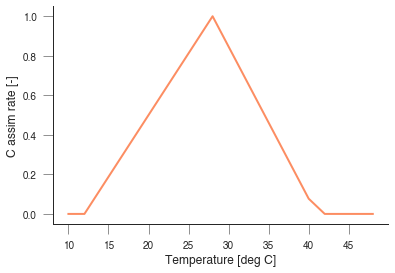

In [2]:
def temp_constraint(temp, t_min=12, t_max=41, t_opt=28):
    f_temp = np.zeros_like(temp)
    f_temp[temp < t_min] = 0.
    f_temp = np.where(np.logical_and(t_min <= temp, temp <= t_opt),
             (temp - t_min)/(t_opt - t_min),
             f_temp)
    f_temp = np.where(temp >= t_opt,
             (t_max - temp)/(t_max-t_opt),
             f_temp)
    f_temp[f_temp<0] = 0.
    return f_temp
temp_axs = np.arange(10, 50, 2)
plt.plot(temp_axs, temp_constraint(temp_axs))
plt.xlabel("Temperature [deg C]")
plt.ylabel("C assim rate [-]")

#### Water availability
If we consider that vegetation growth is only limited by water availability, a simple model would basically look at water balance: precipitation minus evapotranspiration. If this balance is positive (more rain than ET), we may initially conclude that in principle, crops will not be stressed by drought. One of the simplest ways to calculate ET is to use a version of Hargreaves equation:

$$
ET_{0} = \frac{0.0023}{\lambda}\cdot \left[T_{max} - T_{min} \right]^{0.5}\cdot R_{surf}\left[T_{mean} - 17.8\right]
$$
where the daily reference evapotranspiration $ET_0$ is given in $[mm\cdot d^{1}]$, $T_{max,min,mean}$ are respectively the daily max, min and mean temperatures in degrees C, $R_{surf}$ is the surface radiance in $kJm^{-2}d^{-1}$ and $\lambda$ is the latent heat of vaporisation. We only chose this equation for its simplicity. More accurate and better methods are the FAO56/Penman-Monteith approach although it depends on wind speed, an unreliable quantity in our reanalysis dataset.

A very simple but also effective model for the effect of drought (not considering soil moisture!) is to just define a linear scaling point that relates the precipitation/ET ratio (e.g. available water vs water requirements for unstressed photosynthesis):

$$
f(P)=\begin{cases}
\frac{P}{ET_{0}}\, \textrm{if } 0\le P \le ET_{0}\\
1,\, P>ET_{0}\\
\end{cases}
$$


In [3]:
def water_limitation(precip, et):
    return np.where(precip >= et, 1, precip/et)


### Discussion

The code below allows you to plot the stressor functions for different years and different regions. Try to explain the patterns you get. To simplify visualisation, the plots also show a running mean of the stressors.

In [4]:
import ipywidgets as widgets

regions = ["Ashanti",  "Brong_Ahafo",  "Central",  
           "Eastern",  "Greater_Accra",  "Northern",
           "Upper_East",  "Upper_West",  "Volta",
           "Western"]
@widgets.interact(region_name=widgets.Dropdown(
                        options=regions, value='Upper_East', description='Region:',
                        disabled=False,), 
                year=widgets.IntSlider(min=2010, max=2018, value=(2015)))
def plot_stressors(region_name, year):
    meteo_file = sorted([f for f in Path(f'./data/meteo/{region_name}/').glob(f"{region_name}.{year}")])[0]
    df = pd.read_csv(meteo_file, skiprows=20, sep="\t", 
                 names=["station", "year", "doy", "irradiance", "tmin", "tmax", "vpd", "mws", "prec"])
    df.set_index(df['doy'])
    et0 = calc_et0(df.irradiance.values, df.tmin.values, df.tmax.values)
    f_water = water_limitation(df.prec.values, et0)
    f_temp = temp_constraint(df.tmax.values)
    plt.figure(figsize=(15, 5))
    plt.plot(df.doy, f_water, 'o', lw=0.5, mfc="none", label="Water stress")
    plt.plot(df.doy, f_temp, 's', lw=0.5, mfc="none", label="Heat stress")
    plt.plot(df.doy, np.convolve(f_water, np.ones(10)/10., mode="same"), '-', lw=3, label="Smoothed Water Stress")
    plt.plot(df.doy, np.convolve(f_temp, np.ones(10)/10., mode="same"), '-', lw=3, label="Smoothed Heat Stress")
    plt.legend(loc="best")

interactive(children=(Dropdown(description='Region:', index=6, options=('Ashanti', 'Brong_Ahafo', 'Central', '…

In [5]:
@widgets.interact(year=widgets.IntSlider(min=2010, max=2018),
                 product=widgets.Dropdown(options=["LAI", "fAPAR"]))
def plot_lai_stress(year, product):
    product = product.lower()
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, squeeze=True,
                            figsize=(15, 7))
    axs = axs.flatten()
    lai = np.loadtxt(f"data/mcd15_{product}_2003_2018_-022611_106965.txt")

    df = pd.read_csv(f"data/meteo/-022611_106965/-022611_106965.{year}", skiprows=20, sep="\t", 
                     names=["station", "year", "doy", "irradiance", "tmin", "tmax", "vpd", "mws", "prec"])
    df.set_index(df['doy'])
    et0 = calc_et0(df.irradiance.values, df.tmin.values, df.tmax.values)
    f_water = water_limitation(df.prec.values, et0)
    f_temp = temp_constraint(df.tmax.values)

    axs[0].plot(df.doy, f_water, 'o', lw=0.5, mfc="none", label="Water stress")
    axs[0].plot(df.doy, f_temp, 's', lw=0.5, mfc="none", label="Heat stress")
    axs[0].plot(df.doy, np.convolve(f_water, np.ones(10)/10., mode="same"), '-', lw=3, label="Smoothed Water Stress")
    axs[0].plot(df.doy, np.convolve(f_temp, np.ones(10)/10., mode="same"), '-', lw=3, label="Smoothed Heat Stress")
    axs[0].legend(loc="best")
    axs[0].set_ylabel("Stress factor [-]")
    
    
    
    if product == "fapar":
        axs[1].plot(np.arange(1, 366, 8), lai[:, year-2003]/100, '-', lw=3)
        axs[1].set_ylabel("fAPAR [-]")
    else:
        axs[1].plot(np.arange(1, 366, 8), lai[:, year-2003]/10, '-', lw=3)
        axs[1].set_ylabel("LAI [m2/m2]")
    axs[1].set_xlabel(f"Day of year/{year} [d]")

interactive(children=(IntSlider(value=2010, description='year', max=2018, min=2010), Dropdown(description='pro…

In [71]:
from scipy.interpolate import UnivariateSpline
@widgets.interact(smoother=widgets.FloatLogSlider(min=-4, max=5))
def func(smoother):
    y = np.loadtxt(f"data/mcd15_fapar_2003_2018_-022611_106965.txt")[:, -3]
    x = np.arange(1, 366, 8)
    xs = np.arange(1, 366)
    spl = UnivariateSpline(x, y)
    spl.set_smoothing_factor(smoother)
    plt.plot(xs, spl(xs), 'b', lw=3)


interactive(children=(FloatLogSlider(value=1.0, description='smoother', max=5.0, min=-4.0), Output()), _dom_cl…

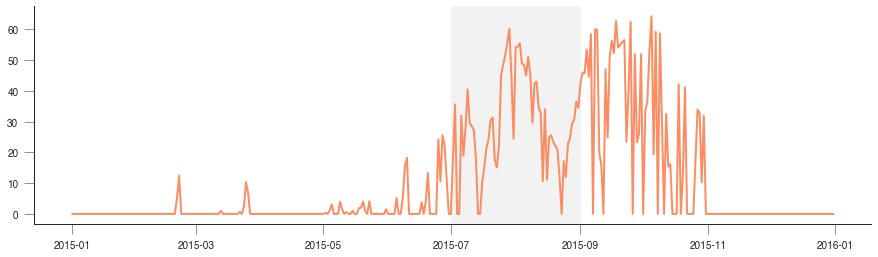

In [68]:
from scipy.interpolate import UnivariateSpline
import matplotlib.dates as mdates
def meteo_calculations(year):
    df = pd.read_csv(f"data/meteo/-022611_106965/-022611_106965.{year}", skiprows=20, sep="\t", 
                     names=["station", "year", "doy", "irradiance", "tmin", "tmax", "vpd", "mws", "prec"])
    df.set_index(df['doy'])
    et0 = calc_et0(df.irradiance.values, df.tmin.values, df.tmax.values)
    f_water = water_limitation(df.prec.values, et0)
    f_temp = temp_constraint(df.tmax.values)
    return f_water, f_temp

def extract_smooth_fapar(product="fapar", year=2018, smoother=100):
    golden_ratio = 0.61803398875
    mask57 = 0b11100000  # Select bits 5, 6 and 7
    product = product.lower()
    year = year-2003
    x = np.arange(1, 366, 8)
    xs = np.arange(1, 366)
    y = np.loadtxt(f"data/mcd15_{product}_2003_2018_-022611_106965.txt")[:, year]
    qa = np.loadtxt("data/mcd15_qa_2003_2018_-022611_106965.txt", dtype=np.uint8)[:, year]
    unc = np.power(golden_ratio, np.right_shift(np.bitwise_and(qa, mask57), 5).astype(np.float32))
    spl = UnivariateSpline(x, y, w=(1./unc)**2)
    spl.set_smoothing_factor(smoother)
    return spl(xs)
    #plt.plot(x, y)
    #plt.plot(xs, spl(xs), 'b', lw=3)

year = 2015

fapar = extract_smooth_fapar(year=year)
f_water, f_temp = meteo_calculations(year=year)
gpp = fapar*f_water*f_temp
plt.figure(figsize=(15, 4))
t_axs = pd.date_range(start=f'1/1/{year}', end=f'12/31/{year}')
plt.plot(t_axs, gpp)
#plt.axhspan(dt.datetime(year, 7, 20), dt.datetime(year, 11, 1))
plt.axvspan(*mdates.datestr2num([f'7/1/{year}', f'9/1/{year}']), color='0.9', alpha=0.5)
    

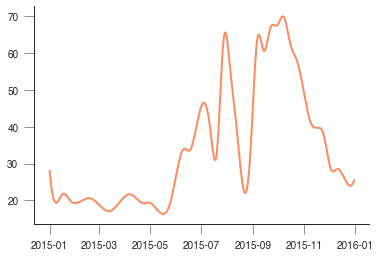

In [70]:
plt.plot(t_axs, fapar)